# Advanced Lane Finding Project

## The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Apply a distortion correction to raw images.
Use color transforms, gradients, etc., to create a thresholded binary image.
Apply a perspective transform to rectify binary image ("birds-eye view").
Detect lane pixels and fit to find the lane boundary.
Determine the curvature of the lane and vehicle position with respect to center.
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

First, I'll compute the camera calibration using chessboard images


 ## Importing Packages

In [1]:
import cv2
import pickle
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline
%matplotlib qt

## Reading and plotting a test image from test_images

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)

This is a Distorted Image


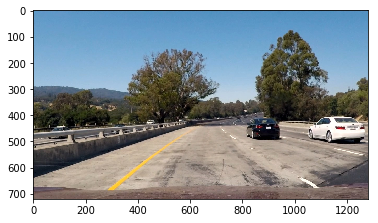

In [2]:
image = mpimg.imread('test_images/test1.jpg')
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  
print('\nThis is a Distorted Image')

## Calibrating the Camera on camera_cal images

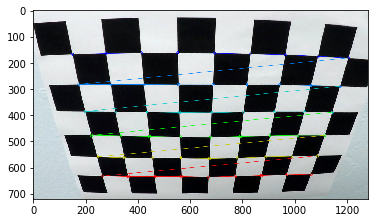

In [3]:
# Arrays to store object points and image points from all the images.

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob('camera_cal/calibration2.jpg')

# Go through the list and search for chessboard corners
for fname in images:
    # Read image
    img = cv2.imread(fname)
    
    #Grayscale the image
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray_img, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
#        cv2.waitKey(0)
# cv2.destroyAllWindows()

# Testing Undistortion Function on camera_cal images


This is an Undistorted Image of Chessboard


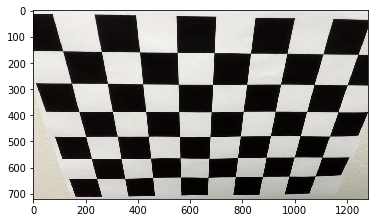

In [4]:
# undist_array = []

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

camera_cal_images = glob.glob('camera_cal/calibration2.jpg')

for fname in camera_cal_images:
    image1 = mpimg.imread(fname)
    undistorted = cal_undistort(image1, objpoints, imgpoints)    
    #undist_array.append(undistorted)
    plt.figure()
    plt.imshow(undistorted)

#    top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
#    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#    f.tight_layout()
#    ax1.imshow(img)
#    ax1.set_title('Original Image', fontsize=50)
#    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
print('\nThis is an Undistorted Image of Chessboard')

# Testing Undistortion Function on Test images


This is an Undistorted Test Images


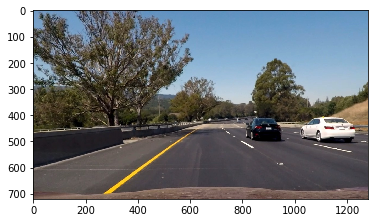

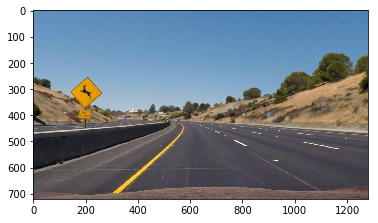

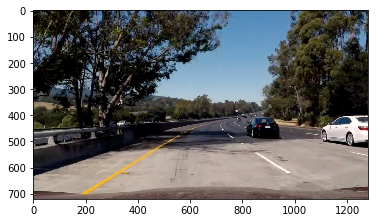

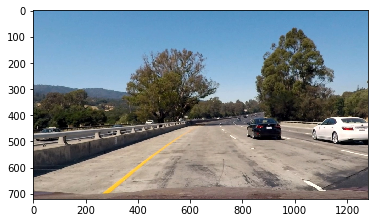

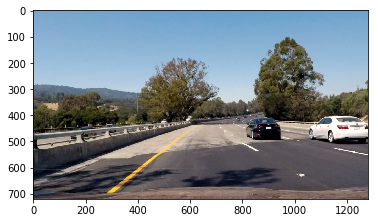

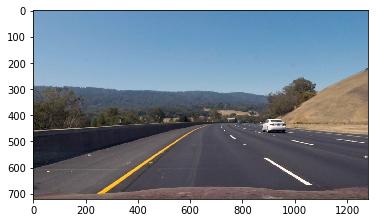

In [5]:
undist_array = []

def cal_undistort(img, objpoints, imgpoints):
#    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

test_images_array = glob.glob('test_images/test*.jpg')
#   print(test_images_array)

for fname in test_images_array:
    image1 = mpimg.imread(fname)
    undistorted = cal_undistort(image1, objpoints, imgpoints)    
    undist_array.append(undistorted)
    plt.figure()
    plt.imshow(undistorted)

#    top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
#    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#    f.tight_layout()
#    ax1.imshow(img)
#    ax1.set_title('Original Image', fontsize=50)
#    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
print('\nThis is an Undistorted Test Images')

## Function to Convert undistorted images to thresholded binary images

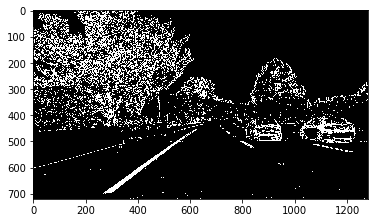

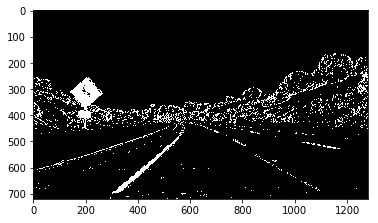

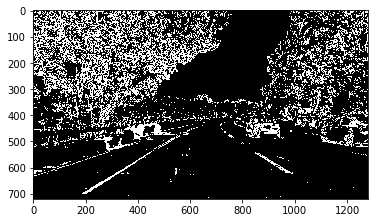

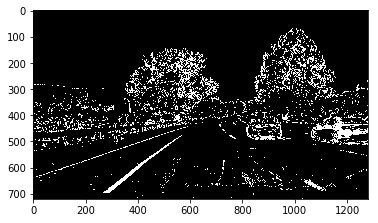

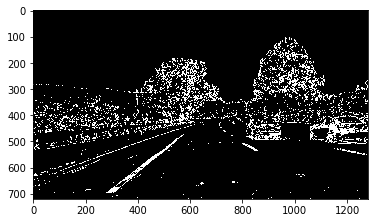

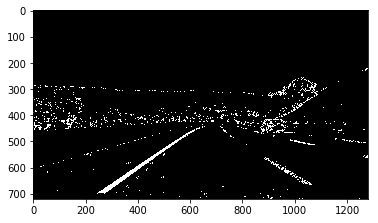

In [6]:
binary_image_array = []

#%matplotlib notebook
#import matplotlib.pyplot as plt

for image in undist_array:
    #image = undistorted
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    binary_image_array.append(combined_binary)
    plt.figure()
    plt.imshow(combined_binary, cmap='gray')


## Define src & dst parameters and applying Perspective Transform on binary images to get warped images

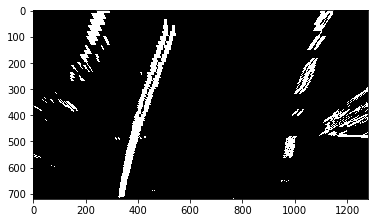

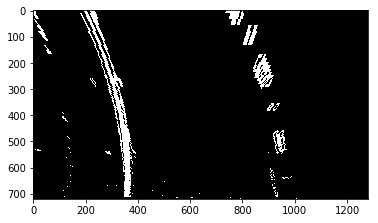

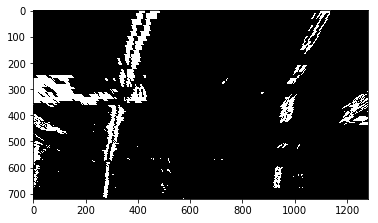

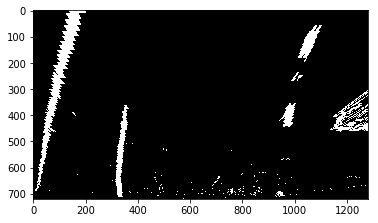

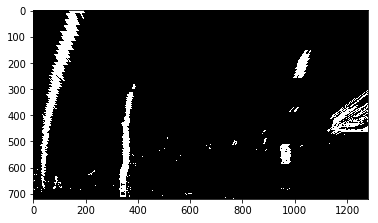

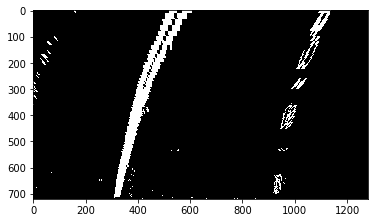

In [7]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

img_size = (image.shape[1], image.shape[0])

src = np.float32([[590,450],[687,450],[1100,720],[200,720]])

dst = np.float32([[300,0],[900,0],[900,720],[300,720]])

M = cv2.getPerspectiveTransform(src, dst)

M_inverse = cv2.getPerspectiveTransform(dst, src)

def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

binary_warped_images = []
for img in binary_image_array:
    warped_image = warper(img, src, dst)
    #warped_image_gray = cv2.cvtColor(warped_image,cv2.COLOR_BGR2GRAY)
    plt.figure()    
#    plt.imshow(M, cmap='Perspective Transformed Image')
#    plt.imshow(M_inverse, cmap='Inverse Perspective Transformed Image')

    plt.imshow(warped_image, cmap='gray')
    binary_warped_images.append(warped_image)

## Finding Lane Pixels and fitting a polynomial using Sliding Window

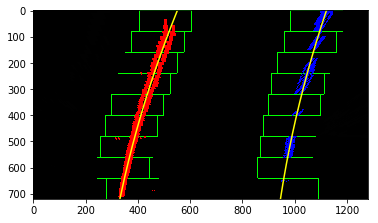

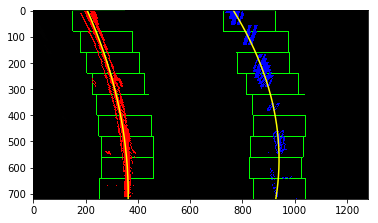

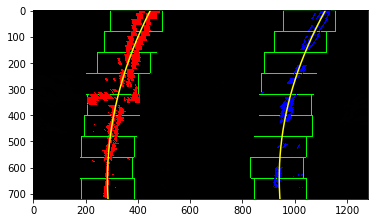

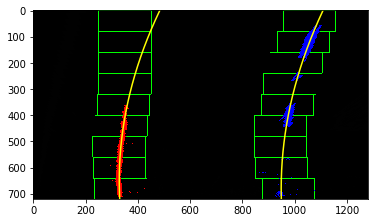

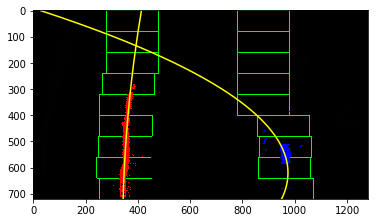

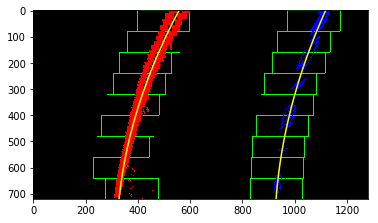

In [8]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


#out_img = fit_polynomial(binary_warped_images[0])
#plt.imshow(out_img)
for img in binary_warped_images:
    result = fit_polynomial(img)
    plt.imshow(result)
    plt.figure()

## Function to find the radius of curvature

In [9]:
def measure_radius_of_curvature(x_values, binary_warped):
    num_rows = binary_warped.shape[0]
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

## Finding the Lines: Search from Prior

Radius of curvature: 1282.05 m
Center offset: 0.01 m
Radius of curvature: 425.24 m
Center offset: 0.01 m
Radius of curvature: 1311.80 m
Center offset: 0.19 m
Radius of curvature: 486.55 m
Center offset: 0.00 m
Radius of curvature: 1215.63 m
Center offset: 0.10 m
Radius of curvature: 672.82 m
Center offset: 0.07 m


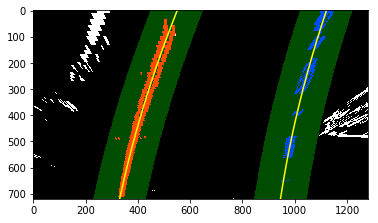

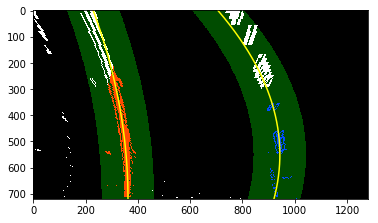

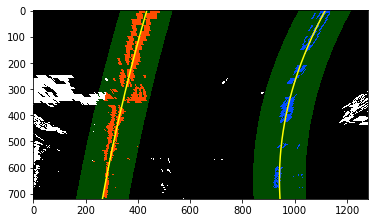

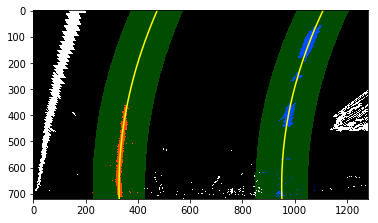

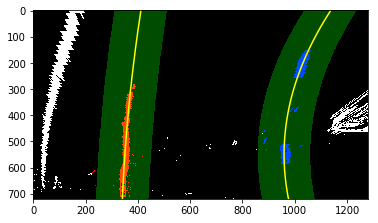

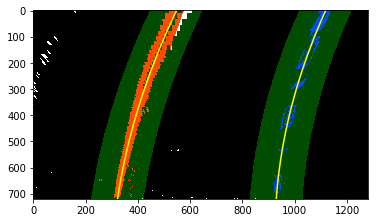

In [10]:
final_lane_images = []

left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    
    left_curve_radius = measure_radius_of_curvature(left_fitx, binary_warped)
    right_curve_radius = measure_radius_of_curvature(right_fitx, binary_warped)
    average_curve_radius = (left_curve_radius + right_curve_radius)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_radius
    print(curvature_string)
    
    road_center = (right_fitx[719] + left_fitx[719])/2
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    center_offset_pixels = abs(img_size[0]/2 - road_center)
    center_offset_meters = xm_per_pix*center_offset_pixels
    offset = "Center offset: %.2f m" % center_offset_meters
    print(offset)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result


# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
for image in binary_warped_images:
    result = search_around_poly(image)
    final_lane_images.append(result)
    plt.imshow(result)
    plt.figure()


## Function for calculating the radius and offset

In [11]:
def radius_and_offset(image):
    margin = 100
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fitx, right_fitx, ploty = fit_poly(image.shape, leftx, lefty, rightx, righty)
    
    left_curve_radius = measure_radius_of_curvature(left_fitx, image)
    right_curve_radius = measure_radius_of_curvature(right_fitx, image)
    average_curve_radius = (left_curve_radius + right_curve_radius)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_radius
    #print(curvature_string)
    
    road_center = (right_fitx[719] + left_fitx[719])/2
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    center_offset_pixels = abs(img_size[0]/2 - road_center)
    center_offset_meters = xm_per_pix*center_offset_pixels
    offset = "Center offset: %.2f m" % center_offset_meters
    #print(offset)
    return curvature_string, offset

## Drawing the Lane Area over final image

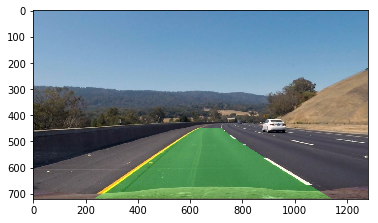

In [12]:
for image in binary_warped_images:
    
    margin = 100
    
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(image.shape, leftx, lefty, rightx, righty)
    
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inverse, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    plt.imshow(result)

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

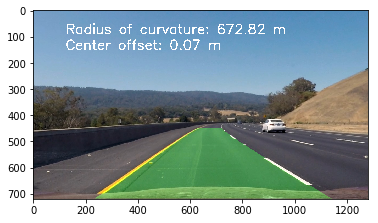

In [14]:
def process_image(image):
    # TODO: put your pipeline here
    initial_image = np.copy(image)
    undistorted = cal_undistort(initial_image, objpoints, imgpoints)
    #gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    warped_image = warper(combined_binary, src, dst)
    #result = fit_polynomial(warped_image)
    #result = search_around_poly(warped_image)
    curvature_string, offset = radius_and_offset(warped_image)
    #print(curvature_string)
    #print(offset)
    margin = 100
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fitx, right_fitx, ploty = fit_poly(warped_image.shape, leftx, lefty, rightx, righty)
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, M_inverse, img_size) 
    result_final = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    cv2.putText(result_final,curvature_string , (125, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.7, (255,255,255), thickness=4)
    cv2.putText(result_final, offset, (125, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.7, (255,255,255), thickness=4)
    return result_final

image123 = mpimg.imread('test_images/test3.jpg')

result_image = process_image(image123)
plt.imshow(result_image, cmap='gray')

# Project Video Output

In [15]:
white_output = 'test_videos_output/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4


100%|█████████▉| 1260/1261 [04:34<00:00,  4.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

CPU times: user 2min 12s, sys: 13.1 s, total: 2min 25s
Wall time: 4min 37s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Challenge Video Output

In [17]:
yellow_output = 'test_videos_output/challenge_video_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video_output.mp4
[MoviePy] Writing video test_videos_output/challenge_video_output.mp4


100%|██████████| 485/485 [01:42<00:00,  4.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video_output.mp4 

CPU times: user 47.6 s, sys: 7.4 s, total: 55 s
Wall time: 1min 45s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Harder challenge Video output

In [19]:
hard_output = 'test_videos_output/harder_challenge_video_output.mp4'
clip2 = VideoFileClip('harder_challenge_video.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(hard_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/harder_challenge_video_output.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [05:28<00:00,  3.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge_video_output.mp4 

CPU times: user 2min 35s, sys: 9.53 s, total: 2min 45s
Wall time: 5min 32s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(hard_output))